In [41]:
import pandas as pd
import string
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import os

stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = str(text).lower()
    text = ''.join([c for c in text if c not in string.punctuation])
    return ' '.join([word for word in text.split() if word not in stop_words])

df = pd.read_csv('./data/news_crawler.csv')

df['title'] = df['title'].fillna('')
df['content'] = df['content'].fillna('')
df['text'] = df['content']
df['text'] = df['text'].apply(preprocess)

os.makedirs('output_model', exist_ok=True)

# Save raw text to re-use in recommendations
df[['title', 'text']].to_csv('output_model/news_texts.csv', index=False)

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer(max_features=50000)
tfidf_matrix = vectorizer.fit_transform(df['text'])

# Save vectorizer and matrix
joblib.dump(vectorizer, 'output_model/tfidf_vectorizer.pkl')
joblib.dump(tfidf_matrix, 'output_model/tfidf_matrix.pkl')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['output_model/tfidf_matrix.pkl']

In [42]:
new_news = pd.read_csv('./output_model/news_texts.csv')
new_news.head(2)

,title,text
0,News News Israel-Gaza war,benjamin netanyahu says hamas seeking changes ...
1,News News War in Ukraine,fire 100 drones night theres little talk cease...


In [43]:
from sklearn.metrics.pairwise import cosine_similarity
news_df = pd.read_csv('./output_model/news_texts.csv')


def get_similar_news(input_text, top_n=3):
    cleaned = preprocess(input_text)
    vector = vectorizer.transform([cleaned])
    sim_scores = cosine_similarity(vector, tfidf_matrix).flatten()
   # print(sim_scores)

    top_indices = sim_scores.argsort()[::-1][:top_n]
    print(top_indices)
    similar_news = news_df.iloc[top_indices]
    
    return similar_news[['title']].to_dict(orient='records')

In [45]:
text = """ A second-year student of the Indian Institute of Management-Calcutta has been arrested after a woman alleged she was raped inside the hostel at the premier institute.

The police have charged the accused under various sections of the Bharatiya Nyaya Sanhita, including rape, and seized his clothes and phone for forensic examination. Four others have also been detained and are being questioned.

The woman has alleged that Parmanand Toppaunwar, who hails from Karnataka, called her to the campus in Joka on Friday. She told police that she is a psychologist and the accused her client, and he had asked her to come to the campus for a counselling session. The two had met on social media, she wrote in her complaint
"""

print(get_similar_news(text))

[ 518 2756 1659]
[{'title': 'Man arrested after teenager raped in public toilet'}, {'title': 'Two arrested after school girls in India allegedly made to strip for period check'}, {'title': 'USC campus intersections are dangerous, data shows. Then they became deadly'}]


['setosa' 'versicolor' 'virginica']


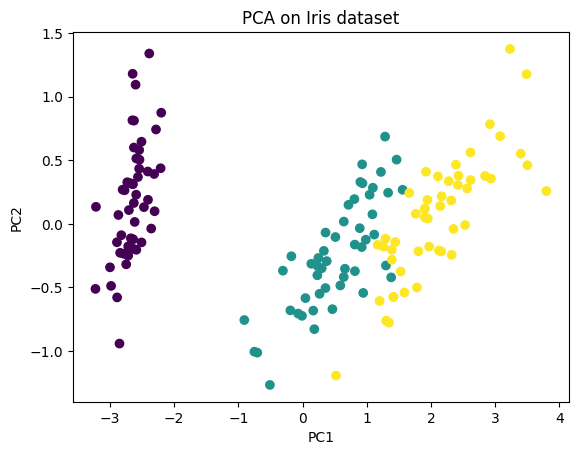

In [ ]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Load data
data = load_iris()
X = data.data
y = data.target

# Apply PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Plot
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y)
plt.title("PCA on Iris dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Use Case: News Article Clustering & Visualization
🎯 Goal:
You have thousands of news articles, and you want to:

Group them into similar topics (unsupervised)

Visualize the data in 2D for exploration

🧠 How PCA Helps:
Convert articles into TF-IDF vectors

Each article becomes a vector of 5,000+ dimensions

Reduce dimensions with PCA (e.g., to 2 or 3)

Capture the major patterns in article similarities

Plot the reduced data to visualize topic clusters

See how articles group by latent structure

(Optional) Apply KMeans clustering on the reduced data

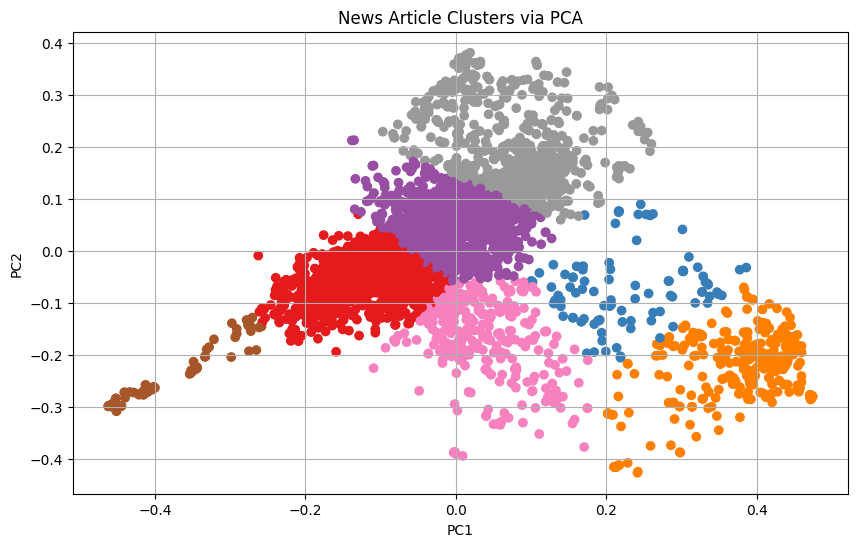

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

# Sample news data
df = pd.read_csv("./data/news_crawler.csv")
texts = df['content']

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts)

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

# KMeans clustering
kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(X_reduced)

# Visualization
plt.figure(figsize=(10,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='Set1')
plt.title("News Article Clusters via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/news_articles.csv")
df.dropna(subset=['title', 'content', 'category'], inplace=True)
df['text'] = df['title'] + ' ' + df['content']


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['text'])


In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)  # reduce to 100 features
X_pca = pca.fit_transform(X_tfidf.toarray())


In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

     business       0.69      0.35      0.47       117
entertainment       0.28      0.57      0.38        47
      general       0.27      0.39      0.32        49
       health       0.57      0.56      0.57       137
      science       0.83      0.52      0.64        94
       sports       0.44      0.71      0.54       102
   technology       0.64      0.48      0.55       153

     accuracy                           0.51       699
    macro avg       0.53      0.51      0.49       699
 weighted avg       0.58      0.51      0.52       699



In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Load and prepare data
df = pd.read_csv("data/news_articles.csv")
df.dropna(subset=['title', 'content', 'category'], inplace=True)

# Combine title + content
df['text'] = df['title'] + ' ' + df['content']

# 2. TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['text'])

# 3. PCA for dimensionality reduction
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_tfidf.toarray())

# 4. Prepare labels and train/test split
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# 5. Train SVM
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("🎯 SVM Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

# 6. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("🌲 Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))


🎯 SVM Classification Report:

               precision    recall  f1-score   support

     business       0.65      0.76      0.70       117
entertainment       0.79      0.32      0.45        47
      general       0.57      0.08      0.14        49
       health       0.82      0.88      0.85       137
      science       0.89      0.90      0.89        94
       sports       0.78      0.91      0.84       102
   technology       0.76      0.86      0.81       153

     accuracy                           0.77       699
    macro avg       0.75      0.67      0.67       699
 weighted avg       0.76      0.77      0.74       699

🌲 Random Forest Classification Report:

               precision    recall  f1-score   support

     business       0.90      0.88      0.89       117
entertainment       0.79      0.79      0.79        47
      general       0.47      0.41      0.43        49
       health       0.92      0.95      0.93       137
      science       0.96      0.97      0.96  

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. Load dataset
df = pd.read_csv("data/news_articles.csv")
df.dropna(subset=['title', 'content', 'category'], inplace=True)
df['text'] = df['title'] + " " + df['content']

# 2. Vectorize text using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['text'])
y = df['category']

# 3. Select K best features using chi-square test
k = 1000  # You can tune this (e.g., 500, 1000, 2000)
selector = SelectKBest(score_func=chi2, k=k)
X_selected = selector.fit_transform(X_tfidf, y)

# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 5. Train SVC classifier
svc_model = SVC(kernel='linear', C=1.0, random_state=42)
svc_model.fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)
print("📊 Support Vector Machine Results:\n")
print(classification_report(y_test, svc_pred))

# 6. Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("🌲 Random Forest Results:\n")
print(classification_report(y_test, rf_pred))


📊 Support Vector Machine Results:

               precision    recall  f1-score   support

     business       0.81      0.86      0.83       117
entertainment       0.89      0.83      0.86        47
      general       0.84      0.33      0.47        49
       health       0.89      0.96      0.93       137
      science       0.95      0.97      0.96        94
       sports       0.95      0.92      0.94       102
   technology       0.82      0.90      0.85       153

     accuracy                           0.87       699
    macro avg       0.88      0.82      0.83       699
 weighted avg       0.87      0.87      0.86       699

🌲 Random Forest Results:

               precision    recall  f1-score   support

     business       0.88      0.90      0.89       117
entertainment       0.84      0.87      0.85        47
      general       0.45      0.41      0.43        49
       health       0.92      0.95      0.93       137
      science       0.92      0.97      0.94        94


Locality Sensitive Hashing (LSH) system using TF-IDF vectors of your news articles to find similar news.

We’ll use:

✅ TfidfVectorizer for vectorizing news content

✅ MinHash + MinHashLSH from datasketch for fast similarity search

✅ MongoDB (optional later) — for now, assume data is in a CSV



Locality Sensitive Hashing (LSH) is a technique used to quickly find approximate nearest neighbors in high-dimensional data, such as text, images, or embeddings.

🧠 Core Idea:
Similar items are more likely to be hashed into the same bucket.

This lets you:

Avoid scanning all data points (as KNN normally does)

Speed up similarity search



In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from datasketch import MinHash, MinHashLSH

# -----------------------------
# 1. Load and preprocess data
# -----------------------------
df = pd.read_csv("data/news_articles.csv")  # columns: title, content
df.dropna(subset=['title', 'content'], inplace=True)
df['text'] = df['title'] + ' ' + df['content']
texts = df['text'].tolist()

# -----------------------------
# 2. Define function to get MinHash from words
# -----------------------------
def get_minhash(text, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for word in set(text.split()):  # use set to avoid repeated updates
        m.update(word.encode('utf8'))
    return m

# -----------------------------
# 3. Create MinHash for each document
# -----------------------------
minhashes = []
keys = []

for idx, text in enumerate(texts):
    key = f"doc_{idx}"
    m = get_minhash(text)
    minhashes.append(m)
    keys.append(key)

# -----------------------------
# 4. Build LSH index
# -----------------------------
lsh = MinHashLSH(threshold=0.5, num_perm=128)

for key, mh in zip(keys, minhashes):
    lsh.insert(key, mh)

print("✅ LSH index created.")

# -----------------------------
# 5. Query similar news
# -----------------------------
def find_similar_articles(index: int):
    print(f"\n🔍 Finding articles similar to: {df.iloc[index]['title']}")
    query_text = texts[index]
    query_minhash = get_minhash(query_text)
    
    results = lsh.query(query_minhash)
    print(f"🧩 Similar articles found ({len(results)}):\n")
    
    for key in results:
        idx = int(key.split('_')[1])
        title = df.iloc[idx]['title']
        print(f"• {title}")

# 🔥 Example usage
find_similar_articles(0)  # change the index to test other articles


min hash--> <datasketch.minhash.MinHash object at 0x0000017D4174B790>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D41990E50>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D417F8810>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D41057290>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D417F8BD0>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D418B6ED0>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D418B5590>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D418B5090>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D418B5890>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D417F8910>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D418B4710>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D418B5A90>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D418B57D0>
min hash--> <datasketch.minhash.MinHash object at 0x0000017D418B4510>
min hash--> <dataske

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# -----------------------------
# 1. Load and Prepare Data
# -----------------------------
df = pd.read_csv("data/news_articles.csv")  # Make sure columns: title, content
df.dropna(subset=["title", "content"], inplace=True)
df['text'] = df['title'] + " " + df['content']
texts = df['text'].tolist()

# -----------------------------
# 2. TF-IDF Vectorization
# -----------------------------
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(texts)

# -----------------------------
# 3. Train KNN Model
# -----------------------------
knn = NearestNeighbors(n_neighbors=5, metric='cosine')  # Can use euclidean, cosine, etc.
knn.fit(X_tfidf)

print("✅ KNN model trained on TF-IDF vectors.")

# -----------------------------
# 4. Query Similar Articles
# -----------------------------
def find_similar_articles(index: int, top_k=5):
    print(f"\n🔍 Input article: {df.iloc[index]['title']}")
    input_vector = X_tfidf[index]

    distances, indices = knn.kneighbors([input_vector.toarray()[0]], n_neighbors=top_k)
    
    print(f"\n🧩 Top {top_k} similar articles:")
    for i, idx in enumerate(indices[0]):
        if idx == index:
            continue  # skip the same article
        print(f"{i+1}. {df.iloc[idx]['title']} (distance: {distances[0][i]:.4f})")

# 🔥 Example usage:
find_similar_articles(0)  # Try changing index to test other queries


✅ KNN model trained on TF-IDF vectors.

🔍 Input article: “We’re Watching a Brain Drain in Real Time”: OpenAI Hit Hard as 4 Top Researchers Defect to Rival Tech Giant Meta - Rude Baguette

🧩 Top 5 similar articles:
2. “We’re Watching a Brain Drain in Real Time”: OpenAI Hit Hard as 4 Top Researchers Defect to Rival Tech Giant Meta - Rude Baguette (distance: 0.0000)
3. “We’re Watching a Brain Drain in Real Time”: OpenAI Hit Hard as 4 Top Researchers Defect to Rival Tech Giant Meta - Rude Baguette (distance: 0.0000)
4. “We’re Watching a Brain Drain in Real Time”: OpenAI Hit Hard as 4 Top Researchers Defect to Rival Tech Giant Meta - Rude Baguette (distance: 0.0000)
5. “We Only Need a Few More Miracles”: Microsoft AI Pioneer Says Human-Level Intelligence Is Closer Than Anyone Realized - Rude Baguette (distance: 0.4373)
